In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score

import pandas as pd 
import numpy as np 

import os
import sys 
import wget

import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline
sns.set_style('ticks')

# Download census-income dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'

INPUT_PATH = '/working/input/adult'


# Load data and split

In [3]:
train = pd.read_csv(os.path.join(INPUT_PATH,'adult.data'))

In [4]:
target = '<=50K'
if 'Set' not in train.columns:
    train['Set'] = np.random.choice(['Train','Valid','Test'],p=[.8,.1,.1],size=(train.shape[0],))
    
train_index = train[train.Set=='Train'].index
valid_index = train[train.Set=='Valid'].index
test_index = train[train.Set=='Test'].index

# Simple preprocessing
Label encode cate cols and fill empty cells

In [5]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims = {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique)
        le = LabelEncoder()
        train[col] = train[col].fillna('VV_likely')
        train[col] = le.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(le.classes_)
    else:
        train.fillna(train.loc[train_index,col].mean(),inplace=True)

age <bound method IndexOpsMixin.nunique of 0        39
1        50
2        38
3        53
4        28
         ..
32556    27
32557    40
32558    58
32559    22
32560    52
Name: age, Length: 32561, dtype: int64>
workclass <bound method IndexOpsMixin.nunique of 0                State-gov
1         Self-emp-not-inc
2                  Private
3                  Private
4                  Private
               ...        
32556              Private
32557              Private
32558              Private
32559              Private
32560         Self-emp-inc
Name: workclass, Length: 32561, dtype: object>
education <bound method IndexOpsMixin.nunique of 0          Bachelors
1          Bachelors
2            HS-grad
3               11th
4          Bachelors
            ...     
32556     Assoc-acdm
32557        HS-grad
32558        HS-grad
32559        HS-grad
32560        HS-grad
Name: education, Length: 32561, dtype: object>
education-num <bound method IndexOpsMixin.nunique of 0        13


In [11]:

# check that pipeline accepts strings
train.loc[train['target']==0, 'target'] = "wealthy"
train.loc[train['target']==1, 'target'] = "not_wealthy"

# Define categorical features for categorical embeddinngs

In [15]:
unused_feat = ['Set']

features = [col for col in train.columns if col not in unused_feat + ['target']]
cate_idxs = [i for i, f in enumerate(features) if f in categorical_columns]
cate_dims = [categorical_dims[f] for i,f in enumerate(features) if f in categorical_columns]

# Network parameters

In [25]:
clf = TabNetClassifier(cat_idxs=cate_idxs,
                       cat_dims=cate_dims,
                       cat_emb_dim=1,
                       optimizer_fn = torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={
                           'step_size':50,
                           'gamma':0.9,                           
                       },
                       scheduler_fn= torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax'
                      )

Device used : cpu


# Training

In [29]:
X_train = train[features].values[train_index]
y_train = train['target'].values[train_index]

X_valid = train[features].values[valid_index]
y_valid = train['target'].values[valid_index]

X_test = train[features].values[test_index]
y_test = train['target'].values[test_index]

In [30]:
max_epochs = 1000

In [35]:
clf.fit(
    X_train=X_train,
    y_train=y_train,
    eval_set=[(X_train,y_train),(X_valid,y_valid)],
    eval_name=['Train','Valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False
)

epoch 0  | loss: 0.3226  | Train_auc: 0.93854 | Valid_auc: 0.92009 |  0:00:03s
epoch 1  | loss: 0.313   | Train_auc: 0.93909 | Valid_auc: 0.92149 |  0:00:06s
epoch 2  | loss: 0.32089 | Train_auc: 0.93853 | Valid_auc: 0.91922 |  0:00:09s
epoch 3  | loss: 0.31895 | Train_auc: 0.93912 | Valid_auc: 0.92097 |  0:00:13s
epoch 4  | loss: 0.31539 | Train_auc: 0.94033 | Valid_auc: 0.92012 |  0:00:16s
epoch 5  | loss: 0.3133  | Train_auc: 0.93958 | Valid_auc: 0.92249 |  0:00:19s
epoch 6  | loss: 0.31445 | Train_auc: 0.93877 | Valid_auc: 0.92059 |  0:00:22s
epoch 7  | loss: 0.31605 | Train_auc: 0.93872 | Valid_auc: 0.91732 |  0:00:26s
epoch 8  | loss: 0.31432 | Train_auc: 0.93911 | Valid_auc: 0.92205 |  0:00:29s
epoch 9  | loss: 0.31499 | Train_auc: 0.941   | Valid_auc: 0.92244 |  0:00:32s
epoch 10 | loss: 0.30764 | Train_auc: 0.94078 | Valid_auc: 0.9229  |  0:00:36s
epoch 11 | loss: 0.30819 | Train_auc: 0.94056 | Valid_auc: 0.92205 |  0:00:39s
epoch 12 | loss: 0.30886 | Train_auc: 0.9398  | Vali

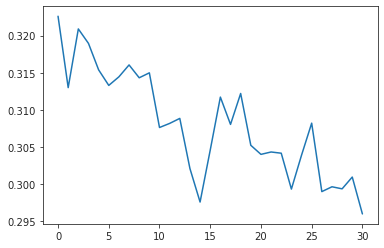

In [36]:
# plot losses

plt.plot(clf.history['loss'])

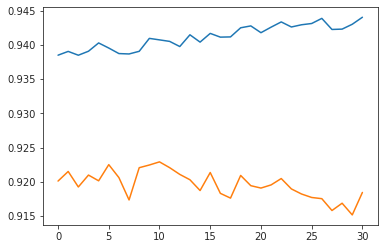

In [37]:
# plot auc
plt.plot(clf.history['Train_auc'])
plt.plot(clf.history['Valid_auc'])

In [ ]:
# plot learning rates
plt.plot(clf.history['lr'])

# Predictions

In [40]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR : {test_auc}")

BEST VALID SCORE FOR : 0.9229003341472818
FINAL TEST SCORE FOR : 0.9225417589111057


# Global explainability: feat importance summing

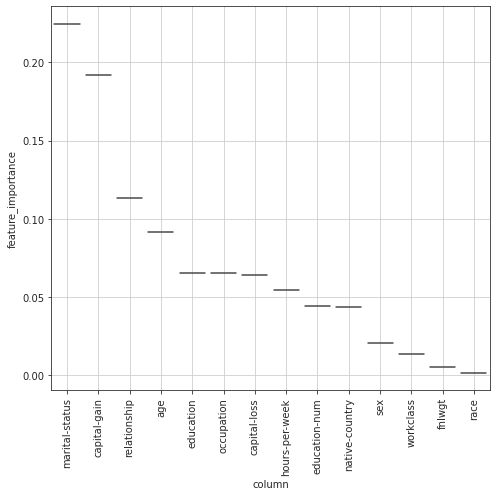

In [59]:
def visualize_importance(models,df):
    feature_importance_df = pd.DataFrame()
    
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = df.columns
        _df['fold'] = i+1
        feature_importance_df = pd.concat([feature_importance_df,_df],axis=0,ignore_index=True)
    
    order = feature_importance_df.groupby('column').sum()[['feature_importance']].sort_values('feature_importance',ascending=False).index
    
    fig, ax = plt.subplots(figsize=(max(6, len(order)*.5),7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig,ax

fig, ax = visualize_importance([clf],train[features] )

# Local explainability and masks

In [60]:
explain_matrix, masks = clf.explain(X_test)

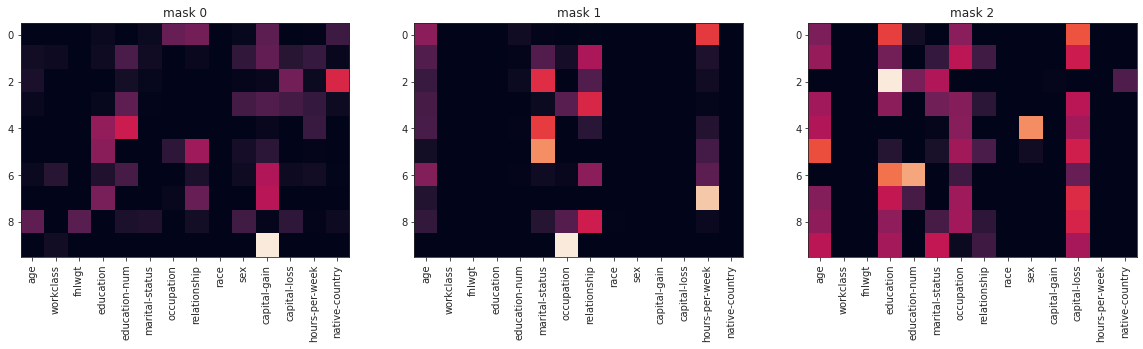

In [80]:
fig, ax = plt.subplots(1,3, figsize=(20,20))

for i in range(3):
    ax[i].imshow(masks[i][:10])
    ax[i].set_xticks([i for i in range(len(train[features].columns))])
    ax[i].set_xticklabels(train[features].columns)
    ax[i].tick_params(axis='x', rotation=90)
    ax[i].set_title(f'mask {i}')

In [69]:
train[features].shape

(32561, 14)

In [76]:
[i for i in range(len(train[features].columns))]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]